In [17]:
#!pip3 install autokeras
#!pip3 install matplotlib

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf

import logging
logging.getLogger('tensorflow').disabled = True

from sklearn.datasets import load_files
from tensorflow.keras.datasets import mnist
import autokeras as ak

import copy 
import os
import json

import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.datasets import make_classification
from plotly.subplots import make_subplots

#from mylib import plot_roc, plot_pr_curve, plot_roc_train_test, plot_pr_train_test, hyper_table, predic_error_analysis, plot_pr_multi_class

In [19]:
n_gpu = len(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", n_gpu)
if n_gpu:
    ! nvidia-smi

Num GPUs Available:  1
Fri Apr 30 07:49:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla T4     On   | 00000000:00:1E.0 Off |                    0 |
| N/A   25C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

## A Simple Example
The first step is to prepare your data. Here we use the MNIST dataset as an example


The second step is to run the ImageClassifier.
It is recommended have more trials for more complicated datasets.
This is just a quick demo of MNIST, so we set max_trials to 1.
For the same reason, we set epochs to 10.
You can also leave the epochs unspecified for an adaptive number of epochs.


In [20]:
data = pd.read_csv('new_multiclasses.csv')
data

,file,blank,ps1,ps2,multi,ice,badice,mos1,mos2,Y
0,fake_00001.pgm,0,1,0,0,1,0,0.892528,0.000000,ps1+ice
1,fake_00002.pgm,0,0,1,1,0,0,0.581729,0.568217,ps2+multi
2,fake_00003.pgm,0,1,0,0,0,0,0.508285,0.000000,ps1
3,fake_00004.pgm,0,1,0,0,0,0,0.852589,0.000000,ps1
4,fake_00005.pgm,0,0,1,0,0,0,0.762097,0.000000,ps2
...,...,...,...,...,...,...,...,...,...,...
26573,fake_38737.pgm,0,1,0,0,0,0,0.897076,0.000000,ps1
26574,fake_38738.pgm,0,1,0,0,0,0,0.646006,0.000000,ps1
26575,fake_38740.pgm,0,1,1,1,0,0,0.529205,0.716043,ps1+ps2+multi
26576,fake_38741.pgm,0,1,0,0,0,0,0.752521,0.000000,ps1


In [21]:
lable_count = dict(data['Y'].value_counts())
lable_count

{'ps1': 9611,
 'ps1+ps2+multi': 5142,
 'ps2+multi': 2558,
 'ps1+multi': 2550,
 'ps1+ice': 1624,
 'ps2+ice': 1612,
 'ps2': 1589,
 'ps1+ps2+multi+ice': 869,
 'ps2+multi+ice': 420,
 'ps1+multi+ice': 397,
 'blank': 77,
 'ps1+ps2': 75,
 'ps1+ps2+ice': 26,
 'ps2+ice+badice': 13,
 'ps1+ice+badice': 7,
 'ps2+multi+ice+badice': 4,
 'ps1+multi+ice+badice': 2,
 'ps1+ps2+multi+ice+badice': 2}

In [22]:
new_data = pd.concat([data[data['Y']==y][:100] if lable_count[y]>100 else data[data['Y']==y] for y in np.unique(data['Y'])])
new_data

,file,blank,ps1,ps2,multi,ice,badice,mos1,mos2,Y
435,fake_00460.pgm,1,0,0,0,0,0,0.000000,0.000000,blank
455,fake_00482.pgm,1,0,0,0,0,0,0.000000,0.000000,blank
471,fake_00499.pgm,1,0,0,0,0,0,0.000000,0.000000,blank
2195,fake_02901.pgm,1,0,0,0,0,0,0.000000,0.000000,blank
2284,fake_03040.pgm,1,0,0,0,0,0,0.000000,0.000000,blank
...,...,...,...,...,...,...,...,...,...,...
6019,fake_08555.pgm,0,0,1,1,1,0,0.850695,0.815657,ps2+multi+ice
13,fake_00014.pgm,0,0,1,1,1,1,0.516343,0.681703,ps2+multi+ice+badice
46,fake_00047.pgm,0,0,1,1,1,1,0.822762,0.710859,ps2+multi+ice+badice
114,fake_00115.pgm,0,0,1,1,1,1,0.603269,0.832699,ps2+multi+ice+badice


In [23]:
imgs = []
imgs_arr = []
imgs_drop = []
for f in new_data['file']:
    f = f.replace('pgm','png')
    try:
        image = tf.keras.preprocessing.image.load_img("./training_data/{}".format(f), color_mode='grayscale') 
        image_array = tf.keras.preprocessing.image.img_to_array(image)
        imgs.append(image)
        imgs_arr.append(image_array)
    except:
        imgs_drop.append(f)
print(len(imgs_drop))

0


In [24]:
input_arr = np.array(imgs_arr)  # Convert single image to a batch.
print(type(input_arr))
print(input_arr.shape)
x_train = np.squeeze(input_arr)
print(x_train.shape)
y_train = np.array(new_data['Y'])
print(y_train.shape)
X = x_train
Y = y_train

<class 'numpy.ndarray'>
(1206, 512, 512, 1)
(1206, 512, 512)
(1206,)


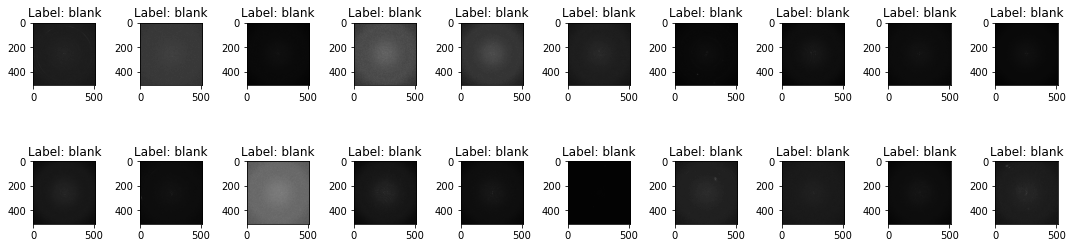

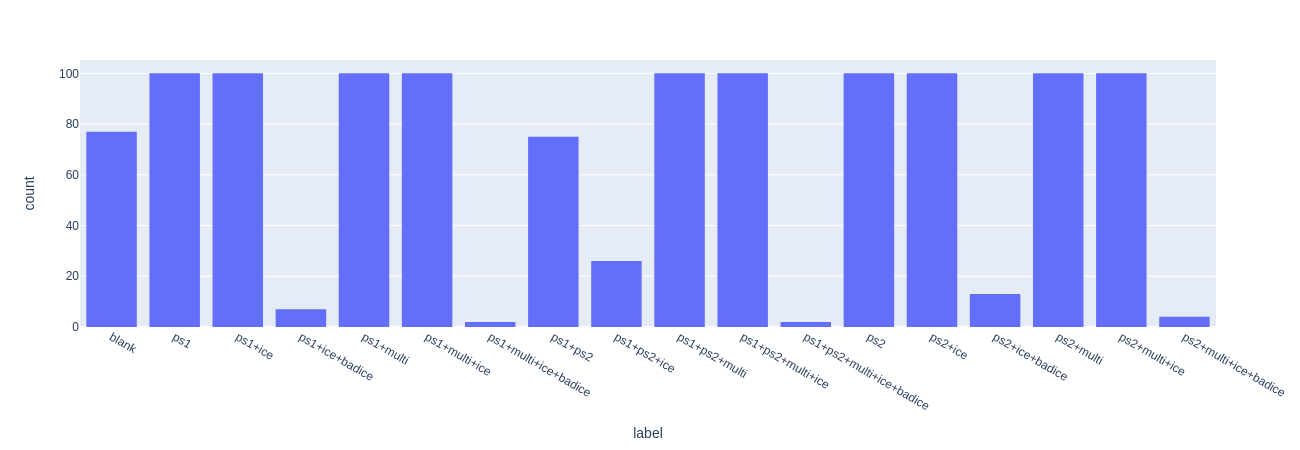

In [25]:
import matplotlib.pyplot as plt
num = 20
k=np.random.randint(len(y_train))
images = x_train[k:(k+num)]
labels = y_train[k:(k+num)]
num_row = 2
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

import plotly.express as px
df = pd.DataFrame(y_train, columns=['label'])
fig = px.histogram(df, x='label', nbins=10)
fig.show()

In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
PATH='image_classifier1'

In [ ]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, directory=PATH, max_trials=10)

# Feed the image classifier with training data. That's it!
clf.fit(x_train, y_train, batch_size=16)


# Predict with the best model.
predicted_y = clf.predict(x_test)
#print(predicted_y)


# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

In [29]:
# performance of the model
model = clf.export_model()

In [91]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512)]   0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 512, 512)     0           input_1[0][0]                    
__________________________________________________________________________________________________
expand_last_dim (ExpandLastDim) (None, 512, 512, 1)  0           cast_to_float32[0][0]            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 1)  3           expand_last_dim[0][0]            
______________________________________________________________________________________________

In [30]:
display(hyper_table(path=PATH+'/image_classifier'))

,trial#1,trial#2,trial#3,trial#4,trial#5,trial#6,trial#7,trial#8,trial#9,trial#10
image_block_1/block_type,vanilla,efficient,efficient,efficient,efficient,resnet,efficient,efficient,efficient,efficient
image_block_1/normalize,True,True,True,True,True,True,True,True,True,True
image_block_1/augment,False,True,True,True,True,True,True,True,True,True
image_block_1/conv_block_1/kernel_size,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
image_block_1/conv_block_1/num_blocks,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
image_block_1/conv_block_1/num_layers,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
image_block_1/conv_block_1/max_pooling,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
image_block_1/conv_block_1/separable,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
image_block_1/conv_block_1/dropout,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
image_block_1/conv_block_1/filters_0_0,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
from tensorflow.keras.models import load_model

try:
    model.save(PATH+"/trained_model", save_format="tf")
except Exception:
    model.save(PATH+"/trained_model.h5")

In [ ]:
loaded_model = load_model(PATH+"/trained_model", custom_objects=ak.CUSTOM_OBJECTS)

In [93]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512)]   0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 512, 512)     0           input_1[0][0]                    
__________________________________________________________________________________________________
expand_last_dim (ExpandLastDim) (None, 512, 512, 1)  0           cast_to_float32[0][0]            
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 1)  3           expand_last_dim[0][0]            
______________________________________________________________________________________________

In [94]:
y_score_test = loaded_model.predict(x_test)
y_score_train = loaded_model.predict(x_train)

In [156]:
def plot_pr_multi_class(y_train, y_score_train, y_test, y_score_test):
    # ROC PR curves for multi-class
    y_class = np.unique(y_train)
    class_dict_test = {}
    for c in y_class:
        score = [s[np.argmax(y_class == c)] for s in y_score_test]
        obs = y_test == c
        class_dict_test[c] = {'obs': obs, 'score': score}

    class_dict_train = {}
    for c in y_class:
        score = [s[np.argmax(y_class == c)] for s in y_score_train]
        obs = y_train == c
        class_dict_train[c] = {'obs': obs, 'score': score}

    fig = make_subplots(rows=1, cols=1)

    # subplot for ROC curve: train data
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1,
        row=1, col=1)

    Y_Scores = [class_dict_train[c]['score'] for c in class_dict_train]
    Y_Obs = [class_dict_train[c]['obs'] for c in class_dict_train]
    Y_Names = y_class
    class2auc = {}
    for i in range(len(Y_Scores)):
        y_true = Y_Obs[i]
        y_score = Y_Scores[i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)
        if not np.isnan(auc_score):
            class2auc[Y_Names[i]] = auc_score
        name = f"class {Y_Names[i]} ROC: Train (AUC={auc_score:.4f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'),row=1, col=1)

    class2count = dict(zip(Y_Names, [sum(obs) for obs in Y_Obs]))    
    class2weight = {}
    for c in class2auc:
        class2weight[c] = class2count[c]
    avg_auc = sum(np.array(list(class2auc.values())) * (np.array(list(class2weight.values()))/sum(class2weight.values())))

    fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
    fig.update_yaxes(title_text="True Positive Rate (Train)", row=1, col=1)
    fig.update_layout(title="Average ROC: {}".format(round(avg_auc,2)))
    fig.show()

    fig = make_subplots(rows=1, cols=1)
    # subplot for ROC curve: train data
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1,
        row=1, col=1)

    Y_Scores = [class_dict_test[c]['score'] for c in class_dict_test]
    Y_Obs = [class_dict_test[c]['obs'] for c in class_dict_test]
    Y_Names = y_class
    class2auc = {}
    for i in range(len(Y_Scores)):
        try:
            y_true = Y_Obs[i]
            y_score = Y_Scores[i]

            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_score = roc_auc_score(y_true, y_score)
            if not np.isnan(auc_score):
                class2auc[Y_Names[i]] = auc_score
            name = f"class {Y_Names[i]} ROC: Test (AUC={auc_score:.4f})"
            fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'),row=1, col=1)
        except:
            print("something wrong in {}".format(Y_Names[i]))

    class2count = dict(zip(Y_Names, [sum(obs) for obs in Y_Obs]))    
    class2weight = {}
    for c in class2auc:
        class2weight[c] = class2count[c]
    avg_auc = sum(np.array(list(class2auc.values())) * (np.array(list(class2weight.values()))/sum(class2weight.values())))

    fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
    fig.update_yaxes(title_text="True Positive Rate (Test)", row=1, col=1)
    fig.update_layout(title="Average ROC: {}".format(round(avg_auc,2)))
    fig.show()

    fig = make_subplots(rows=1, cols=1)
    # subplot for PR curve: train data
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=1, y1=0, 
        row=1,col=1)
    Y_Scores = [class_dict_train[c]['score'] for c in class_dict_train]
    Y_Obs = [class_dict_train[c]['obs'] for c in class_dict_train]
    Y_Names = y_class
    class2auc = {}
    for i in range(len(Y_Scores)):
        try:
            y_true = Y_Obs[i]
            y_score = Y_Scores[i]
            precision, recall, _ = precision_recall_curve(y_true, y_score)
            auc_score = average_precision_score(y_true, y_score)
            if not np.isnan(auc_score):
                class2auc[Y_Names[i]] = auc_score
            name = f"class {Y_Names[i]} PR Train (AUC={auc_score:.4f})"
            fig.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'),row=1,col=1)
        except:
            print("something wrong in {}".format(Y_Names[i]))

    class2count = dict(zip(Y_Names, [sum(obs) for obs in Y_Obs]))    
    class2weight = {}
    for c in class2auc:
        class2weight[c] = class2count[c]
    avg_auc = sum(np.array(list(class2auc.values())) * (np.array(list(class2weight.values()))/sum(class2weight.values())))

    fig.update_xaxes(title_text="Recall", row=1, col=1)
    fig.update_yaxes(title_text="Precision (Train)", row=1, col=1)
    fig.update_layout(title="Average PR: {}".format(round(avg_auc,2)))
    fig.show()

    fig = make_subplots(rows=1, cols=1)
    # subplot for PR curve: test data
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=1, y1=0, 
        row=1,col=1)
    Y_Scores = [class_dict_test[c]['score'] for c in class_dict_test]
    Y_Obs = [class_dict_test[c]['obs'] for c in class_dict_test]
    Y_Names = y_class
    class2auc = {}
    for i in range(len(Y_Scores)):
        try:
            y_true = Y_Obs[i]
            y_score = Y_Scores[i]

            precision, recall, _ = precision_recall_curve(y_true, y_score)
            auc_score = average_precision_score(y_true, y_score)
            if not np.isnan(auc_score):
                class2auc[Y_Names[i]] = auc_score
            name = f"class {Y_Names[i]} PR Test (AUC={auc_score:.4f})"
            fig.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'),row=1,col=1)
        except:
            print("something wrong in {}".format(Y_Names[i]))
            
    class2count = dict(zip(Y_Names, [sum(obs) for obs in Y_Obs]))    
    class2weight = {}
    for c in class2auc:
        class2weight[c] = class2count[c]
    avg_auc = sum(np.array(list(class2auc.values())) * (np.array(list(class2weight.values()))/sum(class2weight.values())))

    fig.update_xaxes(title_text="Recall", row=1, col=1)
    fig.update_yaxes(title_text="Precision (Test)", row=1, col=1)
    fig.update_layout(title="Average PR: {}".format(round(avg_auc,2)))
    fig.show()

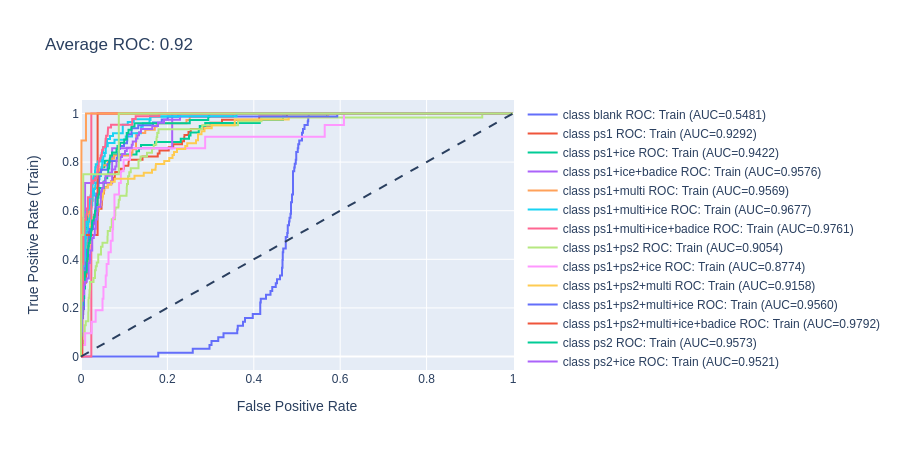

something wrong in ps1+ice+badice
something wrong in ps1+ps2+multi+ice+badice
something wrong in ps2+multi+ice+badice


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



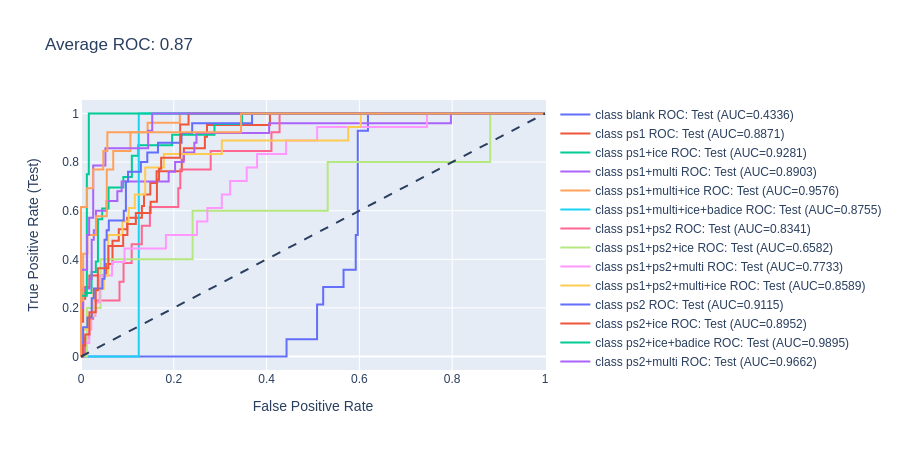

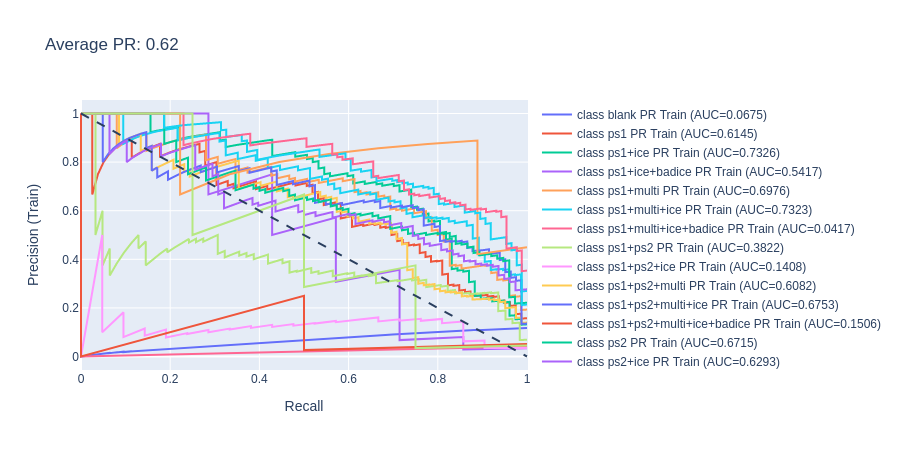

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning:

invalid value encountered in true_divide

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning:

invalid value encountered in true_divide

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning:

invalid value encountered in true_divide

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning:

invalid value encountered in true_divide

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning:

invalid value encountered in true_divide

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning:

invalid value encountered in true_divide



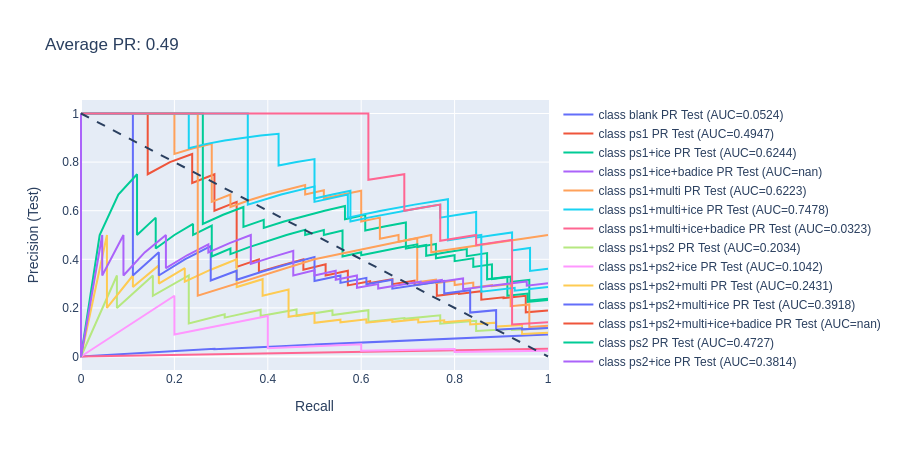

In [157]:
plot_pr_multi_class(y_train, y_score_train, y_test, y_score_test)